<a href="https://colab.research.google.com/github/GajananKuchgave/EVA8_Assignments/blob/main/Assignment_5/EVA8_Session5_BatchNorm_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Model

In [12]:
# Load the Model

!git clone https://github.com/GajananKuchgave/EVA8_Assignments -q --quiet
!mv EVA8_Assignments/Assignment_5/*.py .
!rm -rf EVA8_Assignments

# Import Libraries

In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [16]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalizationMethod='BN').to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,296
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [18]:
from tqdm import tqdm

train_losses = {"BN":[],"GN":[],"LN":[]}
test_losses = {"BN":[],"GN":[],"LN":[]}
train_acc = {"BN":[],"GN":[],"LN":[]}
test_acc = {"BN":[],"GN":[],"LN":[]}

def train(model, device, train_loader, optimizer, epoch, NormalizationName, L1Flag = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # L1 Regularization
    if L1Flag:
        l1_lambda = 1.0e-5
        l1_loss = torch.tensor(0., requires_grad=True)
        l1_loss=l1_loss.to(device)
        for name, param in model.named_parameters():
            l1_loss = l1_loss + l1_lambda*(torch.norm(param, 1))
        loss=loss+l1_loss

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses[NormalizationName].append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[NormalizationName].append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[NormalizationName].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[NormalizationName].append(100. * correct / len(test_loader.dataset))

# Train and test our model using BN + L1 regulerization



In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net(NormalizationName = 'BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, NormalizationName = 'BN', L1Flag = true )
    # scheduler.step()
    test(model, device, test_loader, NormalizationName = 'BN')

EPOCH: 0


Loss=0.10123244673013687 Batch_id=468 Accuracy=94.06: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.0441, Accuracy: 9859/10000 (98.59%)

EPOCH: 1


Loss=0.08578907698392868 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]



Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.04880155250430107 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]



Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 3


Loss=0.053227778524160385 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]



Test set: Average loss: 0.0324, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.03222028538584709 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]



Test set: Average loss: 0.0233, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.0033673334401100874 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]



Test set: Average loss: 0.0254, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.03577601537108421 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]



Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.02676996774971485 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]



Test set: Average loss: 0.0236, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.029704412445425987 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]



Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.03175433352589607 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.006257036235183477 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.018935391679406166 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]



Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.016942579299211502 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.06905112415552139 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.10730651766061783 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.020692115649580956 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.007916092872619629 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.03934321179986 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0224, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.0007921014912426472 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]



Test set: Average loss: 0.0194, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.011112096719443798 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)



# Train and Test them model using Group Normalization

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net(NormalizationName = 'GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, NormalizationName = 'GN' )
    # scheduler.step()
    test(model, device, test_loader, NormalizationName = 'GN')

# Train and Test them model using Layer Normalization

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net(NormalizationName = 'LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, NormalizationName = 'LN' )
    # scheduler.step()
    test(model, device, test_loader, NormalizationName = 'LN')

Text(0.5, 1.0, 'Test Accuracy')

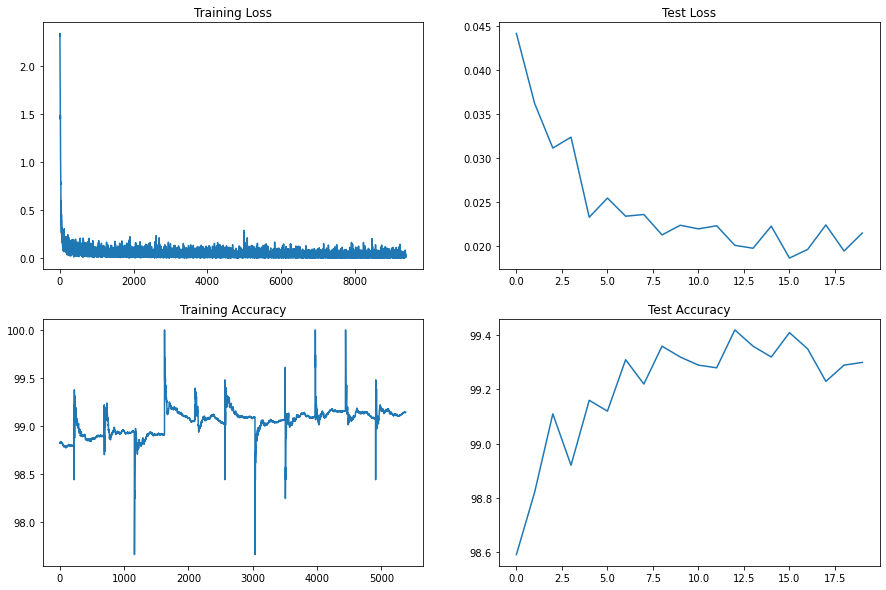

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")